In [67]:
!pip install torch

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [70]:
# Hyperparameters
latent_dim = 100
batch_size = 64
epochs = 50
lr = 0.0001

In [71]:
# Load MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Scale to [-1, 1] for GAN stability
])

train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)


In [72]:
# Generator Network
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh()  # Output in [-1, 1] matching normalized input
        )

    def forward(self, z):
        img = self.main(z)
        return img.view(-1, 1, 28, 28)


In [73]:
# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        flattened = img.view(-1, 784)
        return self.main(flattened)

In [74]:
# Initialize Networks
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Load the saved state dictionaries
generator.load_state_dict(torch.load('/content/SimpleGAN/generator.pth'))
discriminator.load_state_dict(torch.load('/content/SimpleGAN/discriminator.pth'))

# Set to evaluation mode
generator.eval()
discriminator.eval()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [75]:
# Loss and optimizers
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# load their states if available
if os.path.exists('SimpleGAN/g_optimizer.pth'):
    g_optimizer.load_state_dict(torch.load('SimpleGAN/g_optimizer.pth'))
if os.path.exists('SimpleGAN/d_optimizer.pth'):
    d_optimizer.load_state_dict(torch.load('SimpleGAN/d_optimizer.pth'))

Epoch [0/50] | d_loss: 0.4974 | g_loss: 2.3303


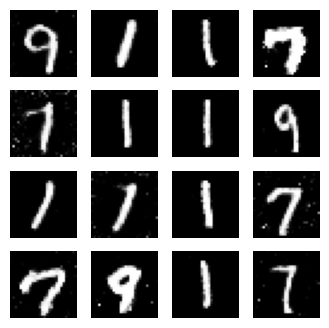

Epoch [5/50] | d_loss: 0.5444 | g_loss: 1.9562


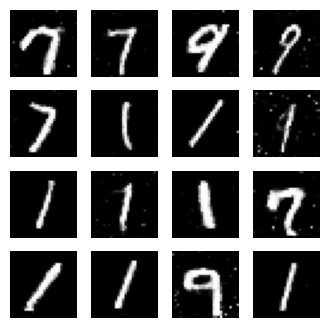

Epoch [10/50] | d_loss: 0.5754 | g_loss: 2.1591


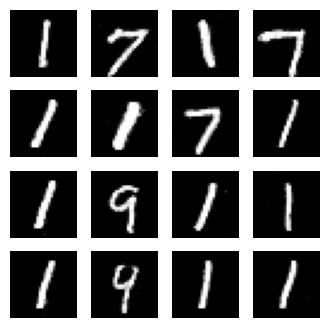

Epoch [15/50] | d_loss: 0.4604 | g_loss: 1.9029


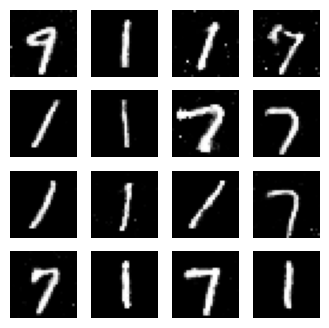

Epoch [20/50] | d_loss: 0.2991 | g_loss: 2.3095


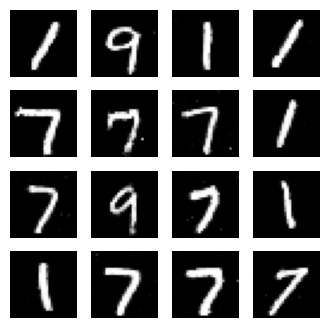

Epoch [25/50] | d_loss: 0.7488 | g_loss: 1.9665


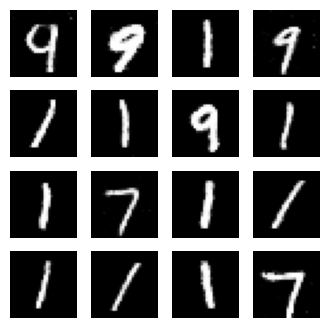

Epoch [30/50] | d_loss: 0.4385 | g_loss: 2.1023


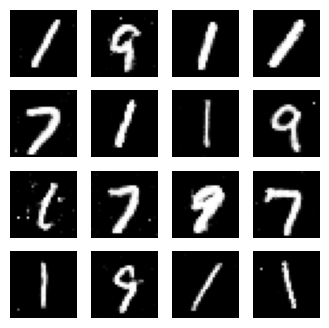

Epoch [35/50] | d_loss: 0.5942 | g_loss: 1.8249


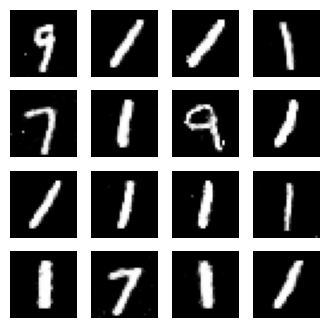

Epoch [40/50] | d_loss: 0.7567 | g_loss: 2.4557


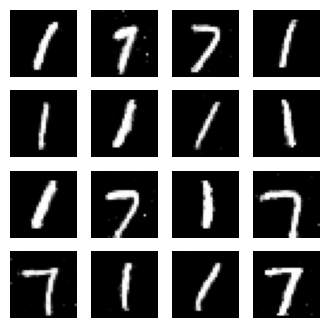

Epoch [45/50] | d_loss: 0.5683 | g_loss: 1.9021


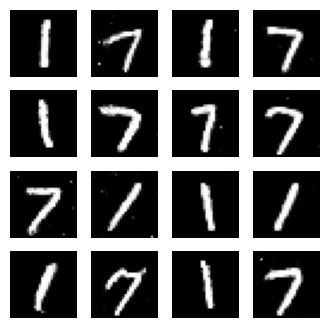

In [76]:
# Training loop
for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(train_loader):
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)

        # Train Discriminator
        d_optimizer.zero_grad()

        # Real images
        real_labels = torch.ones(batch_size, 1).to(device)
        real_output = discriminator(real_imgs)
        d_loss_real = criterion(real_output, real_labels)

        # Fake images
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(z)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        fake_output = discriminator(fake_imgs.detach())
        d_loss_fake = criterion(fake_output, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # --- Train Generator (2x) ---
        for _ in range(2):  # Train generator twice
          g_optimizer.zero_grad()

          # Generate new fake images with correct batch size
          z = torch.randn(batch_size, latent_dim).to(device)
          fake_imgs = generator(z)

          # Ensure labels match current batch size
          gen_labels = torch.ones(batch_size, 1).to(device)

          gen_output = discriminator(fake_imgs)
          g_loss = criterion(gen_output, gen_labels)
          g_loss.backward()
          g_optimizer.step()

    # Print progress and generate samples
    if epoch % 5 == 0:
        print(f"Epoch [{epoch}/{epochs}] | d_loss: {d_loss.item():.4f} | g_loss: {g_loss.item():.4f}")

        with torch.no_grad():
            test_z = torch.randn(16, latent_dim).to(device)
            generated = generator(test_z).cpu()

            plt.figure(figsize=(4,4))
            for i in range(16):
                plt.subplot(4,4,i+1)
                plt.imshow(generated[i,0], cmap='gray', vmin=-1, vmax=1)
                plt.axis('off')
            plt.show()

In [77]:
# Save models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')
print("Models saved!")

# Save optimizers
torch.save(g_optimizer.state_dict(), 'g_optimizer.pth')
torch.save(d_optimizer.state_dict(), 'd_optimizer.pth')

Models saved!
